### introduction

**Deep** learning segmentation is a computer vision technique that uses neural networks to segment images into meaningful regions

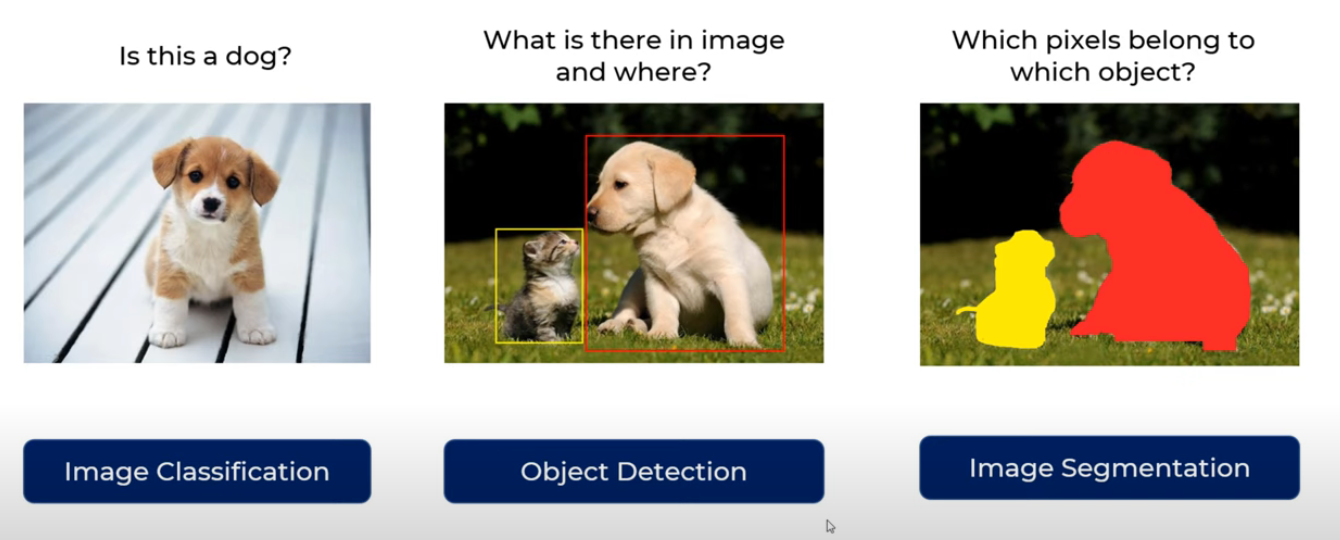

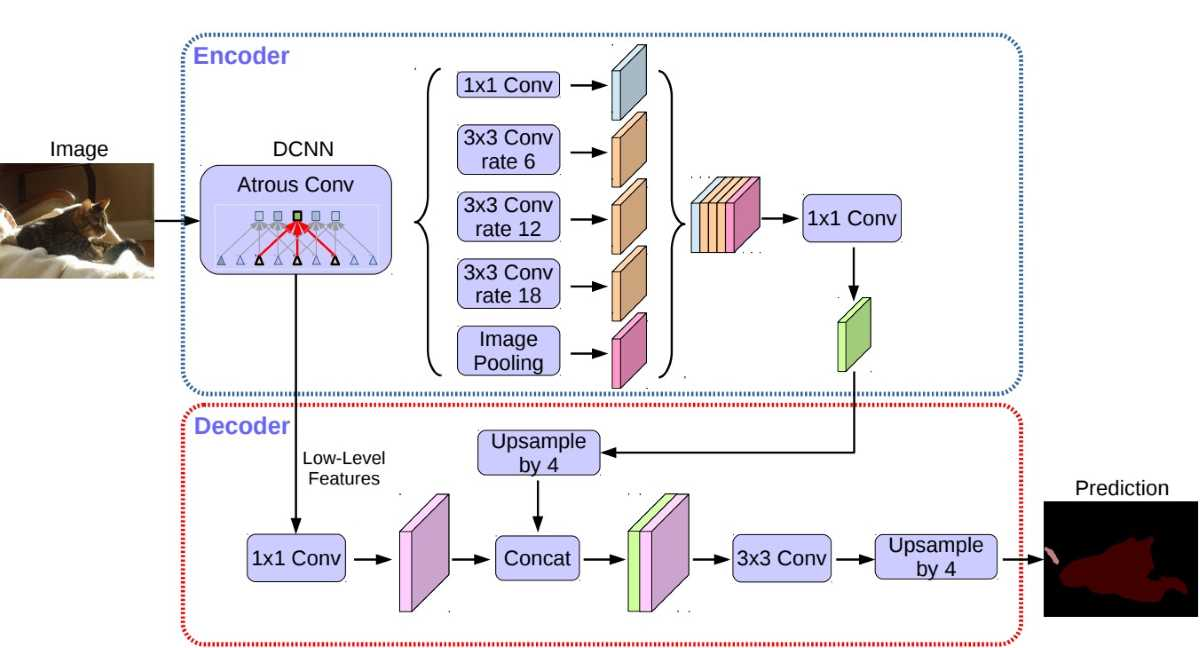

###Downloading Datsets

In [1]:
!gdown 1NGN-p46EP5_So_7pKX3qJ0cg0VeryA38

Downloading...
From: https://drive.google.com/uc?id=1NGN-p46EP5_So_7pKX3qJ0cg0VeryA38
To: /content/UNET-PCB.zip
100% 6.54M/6.54M [00:00<00:00, 43.4MB/s]


In [2]:
!unzip UNET-PCB.zip

Archive:  UNET-PCB.zip
   creating: UNET-PCB/
   creating: UNET-PCB/img/
  inflating: UNET-PCB/img/0.jpg      
  inflating: UNET-PCB/img/1.jpg      
  inflating: UNET-PCB/img/10.jpg     
  inflating: UNET-PCB/img/11.jpg     
  inflating: UNET-PCB/img/12.jpg     
  inflating: UNET-PCB/img/13.jpg     
  inflating: UNET-PCB/img/14.jpg     
  inflating: UNET-PCB/img/15.jpg     
  inflating: UNET-PCB/img/16.jpg     
  inflating: UNET-PCB/img/17.jpg     
  inflating: UNET-PCB/img/18.jpg     
  inflating: UNET-PCB/img/19.jpg     
  inflating: UNET-PCB/img/2.jpg      
  inflating: UNET-PCB/img/20.jpg     
  inflating: UNET-PCB/img/21.jpg     
  inflating: UNET-PCB/img/22.jpg     
  inflating: UNET-PCB/img/23.jpg     
  inflating: UNET-PCB/img/24.jpg     
  inflating: UNET-PCB/img/25.jpg     
  inflating: UNET-PCB/img/26.jpg     
  inflating: UNET-PCB/img/27.jpg     
  inflating: UNET-PCB/img/28.jpg     
  inflating: UNET-PCB/img/29.jpg     
  inflating: UNET-PCB/img/3.jpg      
  inflating: UN

In [10]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Paths
image_dir = "/content/UNET-PCB/img"
mask_dir = "/content/UNET-PCB/mask"

IMG_SIZE = (256, 256)

def load_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        masks.append(mask)
        images.append(img)

    return np.array(images), np.array(masks)

# Load dataset
images, masks = load_data(image_dir, mask_dir)
masks = tf.keras.utils.to_categorical(masks, num_classes=4)

### Modelling

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# --- ASPP Module ---
def ASPP(x, filters=256):
    """Atrous Spatial Pyramid Pooling (ASPP) Module"""
    conv1x1 = layers.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)

    conv3x3_1 = layers.Conv2D(filters, (3, 3), dilation_rate=6, padding="same", activation="relu")(x)
    conv3x3_2 = layers.Conv2D(filters, (3, 3), dilation_rate=12, padding="same", activation="relu")(x)
    conv3x3_3 = layers.Conv2D(filters, (3, 3), dilation_rate=18, padding="same", activation="relu")(x)

    # Global Average Pooling
    global_avg_pool = layers.GlobalAveragePooling2D()(x)
    global_avg_pool = layers.Dense(filters, activation="relu")(global_avg_pool)
    global_avg_pool = layers.Reshape((1, 1, filters))(global_avg_pool)

    # Resize global pooling output to match feature map
    global_avg_pool = layers.UpSampling2D(size=(x.shape[1], x.shape[2]))(global_avg_pool)

    # Concatenate all branches
    x = layers.Concatenate()([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3, global_avg_pool])
    x = layers.Conv2D(filters, (1, 1), activation="relu")(x)  # Reduce depth

    return x

# --- DeepLabV3 Model ---
def DeepLabV3(input_shape=(256, 256, 3), num_classes=4):
    """DeepLabV3 Model with ResNet50 Backbone and ASPP"""

    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

    # Extract feature map from deeper layers
    feature_map = base_model.get_layer("conv4_block6_2_relu").output  # (16x16)

    # Apply ASPP
    aspp_output = ASPP(feature_map)

    # Upsampling to restore original size
    x = layers.Conv2DTranspose(256, (3, 3), strides=2, padding="same", activation="relu")(aspp_output)  # (32x32)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)  # (64x64)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)  # (128x128)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)  # (256x256) ✅ ADDED EXTRA UPSAMPLING

    # Final segmentation output
    output = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)  # (256x256x4)

    return Model(inputs=base_model.input, outputs=output)

# Create the model
model = DeepLabV3()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

# Model Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 11,529,188 (43.98 MB)

 Trainable params: 11,500,644 (43.87 MB)

 Non-trainable params: 28,544 (111.50 KB)

In [12]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=3,
    epochs=200,
    verbose=1
)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9972 - loss: 0.0065 - val_accuracy: 0.9723 - val_loss: 0.6200
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9970 - loss: 0.0074 - val_accuracy: 0.9723 - val_loss: 0.7203
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9963 - loss: 0.0095 - val_accuracy: 0.9754 - val_loss: 0.2013
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9937 - loss: 0.0168 - val_accuracy: 0.9754 - val_loss: 0.1685
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9955 - loss: 0.0121 - val_accuracy: 0.8844 - val_loss: 0.4879
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9959 - loss: 0.0102 - val_accuracy: 0.9369 - val_loss: 0.2544
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9966 - loss: 0.0081 - val_accuracy: 0.9759 - val_loss: 0.0885
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9905 - loss: 0.0289 - val_accuracy: 0.

### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


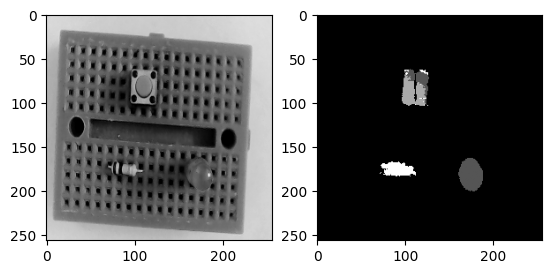

In [18]:
import matplotlib.pyplot as plt

def predict_mask(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    pred_mask = np.argmax(pred, axis=-1)[0]
    return pred_mask

file="/content/UNET-PCB/img/20.jpg"
predicted_mask = predict_mask(model, file)
plt.subplot(1,2,1)
plt.imshow(cv2.resize(cv2.imread(file,0),(256,256)),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(predicted_mask,cmap="gray")
plt.show()

### SaveModel

In [19]:
model.save("DeepLabv3.h5")

In [20]:
from tensorflow.keras.models import load_model

modelx = load_model("DeepLabv3.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


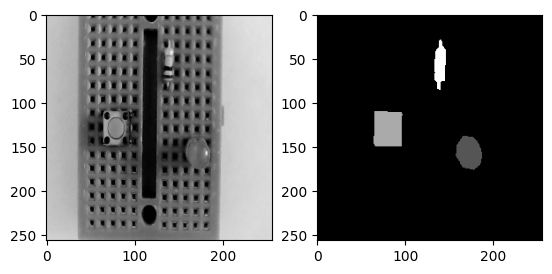

In [21]:
import matplotlib.pyplot as plt

def predict_mask(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = modelx.predict(img)
    pred_mask = np.argmax(pred, axis=-1)[0]
    return pred_mask

file="/content/UNET-PCB/img/1.jpg"
predicted_mask = predict_mask(model, file)
plt.subplot(1,2,1)
plt.imshow(cv2.resize(cv2.imread(file,0),(256,256)),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(predicted_mask,cmap="gray")
plt.show()

### Combined Model ( ensembling )

In [64]:
import tensorflow as tf

modelx = tf.keras.models.load_model("Unet.h5")
modely = tf.keras.models.load_model("DeepLabv3.h5")


In [73]:
# Evaluate U-Net Model
unet_loss, unet_accuracy = modelx.evaluate(X_val,y_val)
print(f"U-Net Validation Accuracy: {unet_accuracy:.4f}")

# Evaluate DeepLabV3 Model
deeplab_loss, deeplab_accuracy = modely.evaluate(X_val,y_val)
print(f"DeepLabV3 Validation Accuracy: {deeplab_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9923 - loss: 0.0222
U-Net Validation Accuracy: 0.9923
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9895 - loss: 0.1752
DeepLabV3 Validation Accuracy: 0.9895


In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Average, Softmax
from tensorflow.keras.models import Model

# Define input shape based on model outputs
input_shape = (256, 256, 4)  # Assuming both models output (256, 256, 4)

# Inputs to the new model (outputs from U-Net and DeepLabV3)
unet_input = Input(shape=input_shape, name="unet_output")
deeplab_input = Input(shape=input_shape, name="deeplab_output")

# Merge the outputs using averaging
merged_output = Average()([unet_input, deeplab_input])  # Simple averaging

# Apply softmax activation to maintain probability distribution
final_output = Softmax()(merged_output)

# Define the ensemble model
ensemble_model = Model(inputs=[unet_input, deeplab_input], outputs=final_output, name="EnsembleModel")

# Compile the model with categorical crossentropy
ensemble_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # Valid since output is softmax
    metrics=["accuracy"]
)

# Print model summary
ensemble_model.summary()


Model: "EnsembleModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ unet_output (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deeplab_output            │ (None, 256, 256, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_10 (Average)      │ (None, 256, 256, 4)    │              0 │ unet_output[0][0],     │
│                           │                        │                │ deeplab_output[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax_4 (Softmax)       │ (None, 256, 256, 4)    │              0 │ average_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Get predictions from both models
unet_pred = modelx.predict(X_val)  # Shape: (num_samples, 256, 256, 4)
deeplab_pred = modely.predict(X_val)  # Shape: (num_samples, 256, 256, 4)

# Evaluate the ensemble model
e_loss, e_accuracy = ensemble_model.evaluate([unet_pred, deeplab_pred], y_val)
print(f"Ensemble Model Validation Accuracy: {e_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9902 - loss: 0.7531
Ensemble Model Validation Accuracy: 0.9902
